**Time to event data analysis for data set ld.chin**

Lexical decision data for Mandarin Chinese (Tsang et al., 2018). Participants were shown a stimulus on the screen and were asked to indicate if this stimulus was a word or nonword.

Author: Jinghua Xu

**Preparing the notebook environment**

In [1]:
library(devtools)
install.packages("ggsignif")
install_github("PeterHendrix13/TTEdata")

Loading required package: usethis

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




✔  checking for file ‘/tmp/RtmpQU6tch/remotesc3b2a7a0b/PeterHendrix13-TTEdata-705fdb2/DESCRIPTION’
─  preparing ‘TTEdata’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
     NB: this package now depends on R (>= 3.5.0)
─  building 'TTEdata_1.0.tar.gz'
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Loading the necessary libraries**

In [2]:
library(survival)
install.packages("survminer")
library(survminer)
library(multcomp)
library(TTEdata)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: magrittr

Loading required package: mvtnorm

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




In [3]:
data(package = "TTEdata")

**View data set**

In [4]:
head(ld.chin)
tail(ld.chin)
dim(ld.chin)

,word,rt,log.frequency,length,sqrt.strokes,snd,log.nwf
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,凡,778.38,3.566407,1,1.732051,0.9775594,3.091042
2,口,682.42,5.042779,1,1.732051,0.9702419,5.283204
3,土,704.94,3.026034,1,1.732051,0.9678224,4.532599
4,女,680.63,6.428571,1,1.732051,0.9726942,4.852030
5,小,651.17,7.564045,1,1.732051,0.9775589,5.703782
6,山,668.08,4.816952,1,1.732051,0.9711855,5.342334


,word,rt,log.frequency,length,sqrt.strokes,snd,log.nwf
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
9597,节衣缩食,877.68,-1.85982420,4,5.830952,0.9224802,4.418841
9598,谋财害命,805.01,-1.64662070,4,6.000000,0.9291793,4.047428
9599,贪得无厌,790.89,-0.52256088,4,5.385165,0.9090908,4.842217
9600,闷闷不乐,709.63,0.07908841,4,4.898979,0.9024619,5.350673
9601,闻风丧胆,843.26,-1.34899858,4,5.477226,0.9147592,4.499810
9602,顾全大局,741.08,-1.76901998,4,5.099020,0.9032092,5.330300


[1] 9602    7

In [5]:
# Round rt
ld.chin$rt = round(ld.chin$rt)

**Inspect data through PDF and CDF plot**

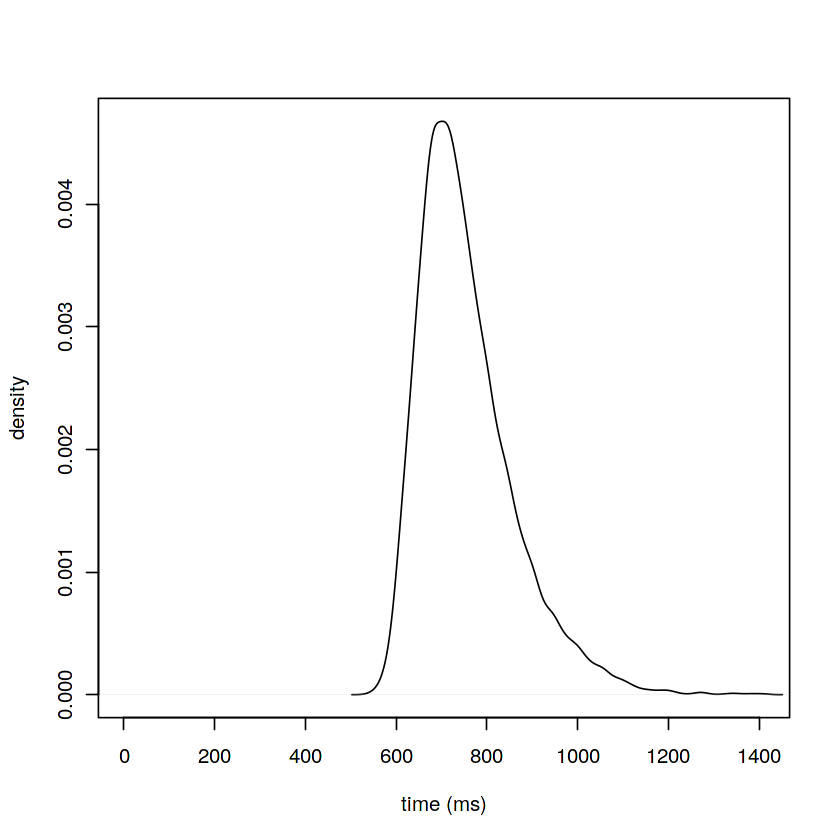

In [6]:
# Density plot
plot(density(ld.chin$rt), xlab = "time (ms)", ylab = "density",
     main = "", xlim = c(0,max(ld.chin$rt)))

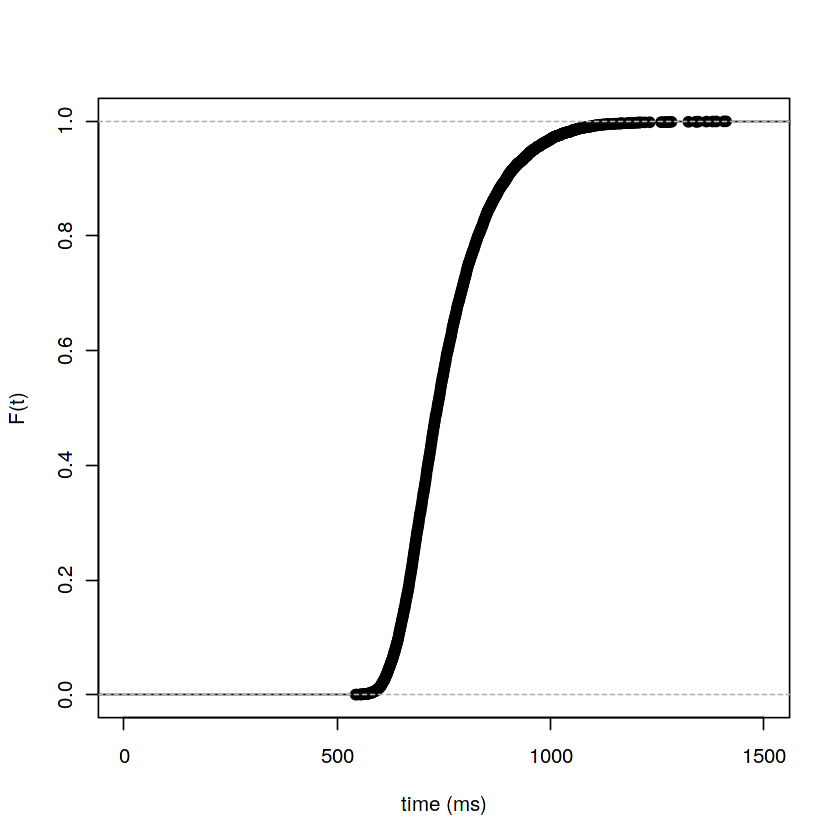

In [7]:
# Cumulative density plot
plot(ecdf(ld.chin$rt), xlab = "time (ms)", ylab = "F(t)",
     main = "", xlim = c(0,1500))

The cumulative density function is the integral over the probability density function from minus infinity to t

**Response tuple: add time and event columns**

In [8]:
# define event status
ld.chin$status = 1
# define time 
ld.chin$time = ld.chin$rt

**Inspect data through survival, hazard and cummulative hazard plot**

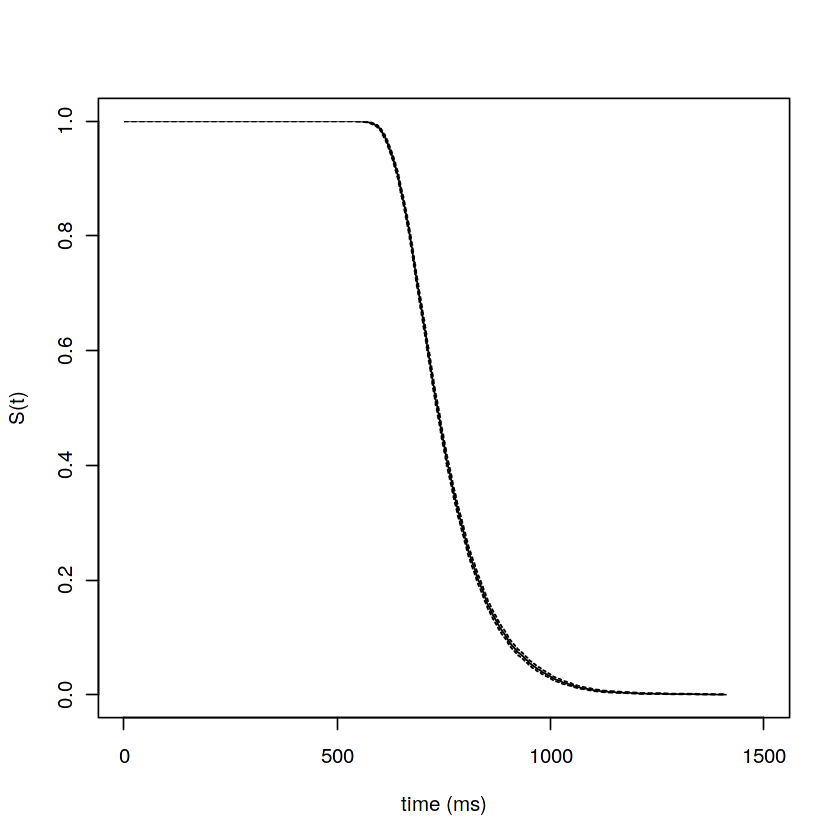

In [9]:
# Define survival object: time-to-event response tuple
surv = Surv(time = ld.chin$rt, event = ld.chin$status)
# Estimate survival function
survival = survfit(surv ~ 1)
# Survival plot
plot(survival, xlab = "time (ms)", ylab = "S(t)",
     main = "", xlim = c(0,1500))

In [10]:
# Retrieve the proportion of trials that are responded to at 600 ms
survival$surv[which(survival$time==600)]

[1] 0.9865653

* The survival function is the integral over the probability density function from t to infinity.
* The survival function can also be formulated in terms of the cumulative density function: S(t) = 1 − F(t), where τ is the time at which the event of interest occurs

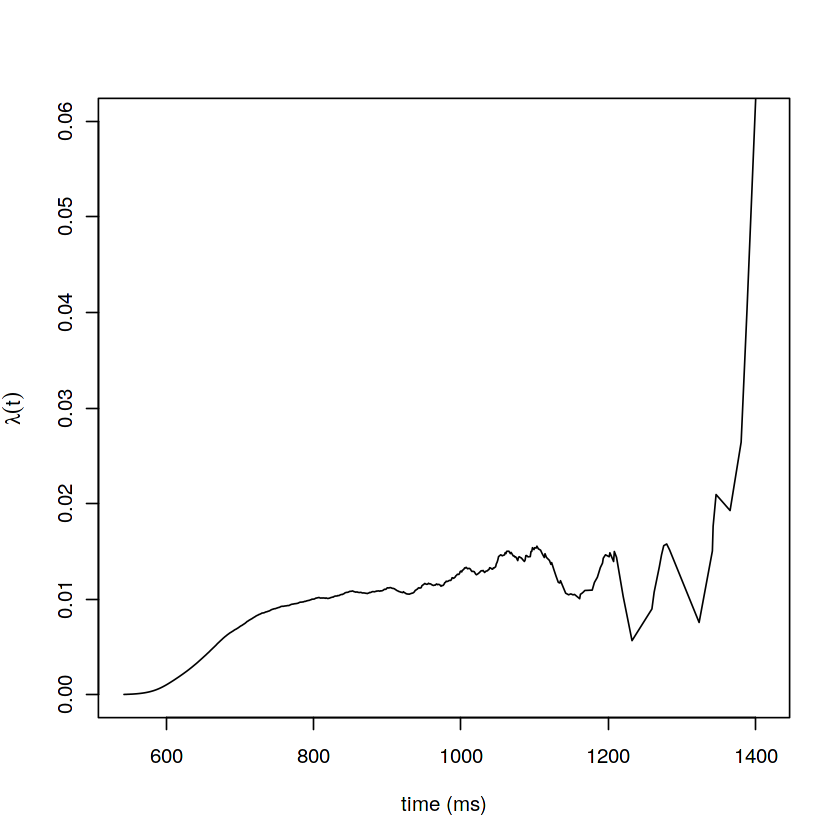

In [11]:
# Estimate probability density function
d = density(ld.chin$rt, from = 1, to = 5000, n = 5000)
# Restrict density function time points
d$y = d$y[which(d$x%in%survival$time)]
d$x = d$x[which(d$x%in%survival$time)]
# Define hazard function
hazard = d$y / survival$surv

# Hazard plot
plot(survival$time, hazard, ylim = c(0, 0.06), xlab = "time (ms)",
     ylab = expression(lambda(t)),type="l")

The hazard function can also be formulated in terms of the probability density function and the survival function: λ(t)= f(t) /S(t) i.e. PDF over survival function,where τ is the time at which the event of interest occurs

In [12]:
# Find the value at which the hazard function reaches its maximum
survival$time[which(hazard==max(hazard))]

[1] 1411

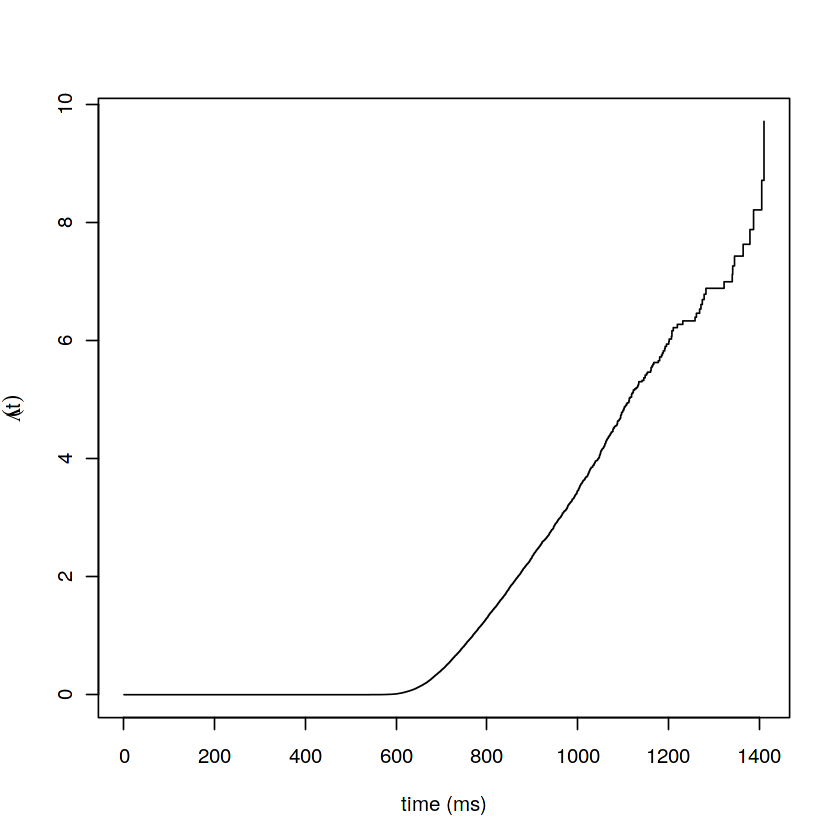

In [13]:
# Hazard plot
plot(survival, cumhaz = TRUE, conf.int = FALSE, xlab = "time (ms)",
     ylab = expression(Lambda(t)))

The cumulative hazard function can also be formulated in terms of the survival function: Λ(t) = −logS(t), i.e. minus log survival function, where τ is the time at which the event of interest occurs

**Predictor effects on the shape of objective functions**

* ** A categorical predictor(2 values): word complexity<br>**
Defined by the number of stokes of a word, we consider the words with sqrt.strokes lower than or equal to 4 as 'simple', otherwise complex, as:

In [14]:
median(ld.chin$sqrt.strokes)
mean(ld.chin$sqrt.strokes)

[1] 4

[1] 4.003188

In [15]:
# Create a categorical predictor
ld.chin$complexity = ifelse(ld.chin$sqrt.strokes <= 4, "simple", "complex")
# Convert to factor
ld.chin$complexity = as.factor(ld.chin$complexity)

Complexity distribution overview

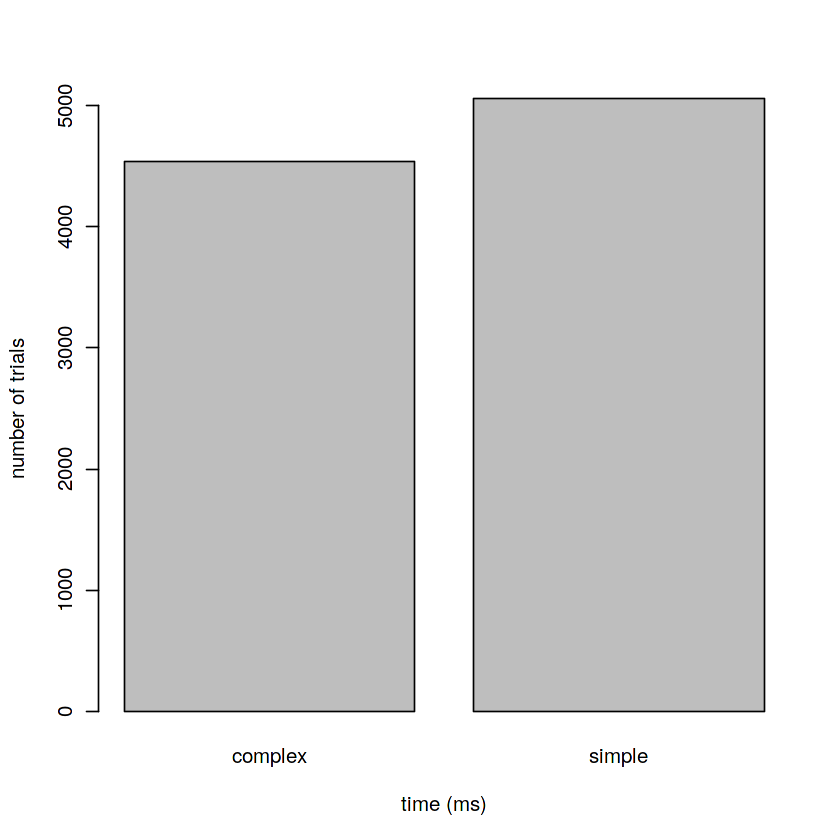

In [16]:
# Generate table of word lengths
tab = table(ld.chin$complexity)
# Make a barplot of the word lengths
barplot(tab, xlab = "time (ms)", ylab = "number of trials")

Fit survival curves.

In [17]:
# Generate survival curves
surv.com = survfit(surv ~ complexity, data = ld.chin)
# Inspect survival curves
surv.com

Call: survfit(formula = surv ~ complexity, data = ld.chin)

                      n events median 0.95LCL 0.95UCL
complexity=complex 4542   4542    739     736     742
complexity=simple  5060   5060    730     727     734

The median respnse time does not differ very much between complex words and simple words. The confidence intervals for median response times for simple and comlex words overlap. This suggests there is a difference between the survival curves for simple and complex words. 

Inspect survival curves.

In [18]:
# Create summary of survival curve
surv.com.sum = surv_summary(surv.com)
# Define columns of interest
cols = c("time","surv","upper","lower","complexity")

# Inspect survival curves at 600 ms
surv.com.sum[which(surv.com.sum$time==600), cols]

# Inspect survival curves at 1,100 ms
surv.com.sum[which(surv.com.sum$time==1100), cols]

Warning message in .get_data(x, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


,time,surv,upper,lower,complexity
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
21,600,0.9903126,0.9931652,0.9874682,complex
549,600,0.9832016,0.9867490,0.9796669,simple


,time,surv,upper,lower,complexity
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1017,1100,0.00770751,0.01053632,0.005638181,simple


Plot survival curves.

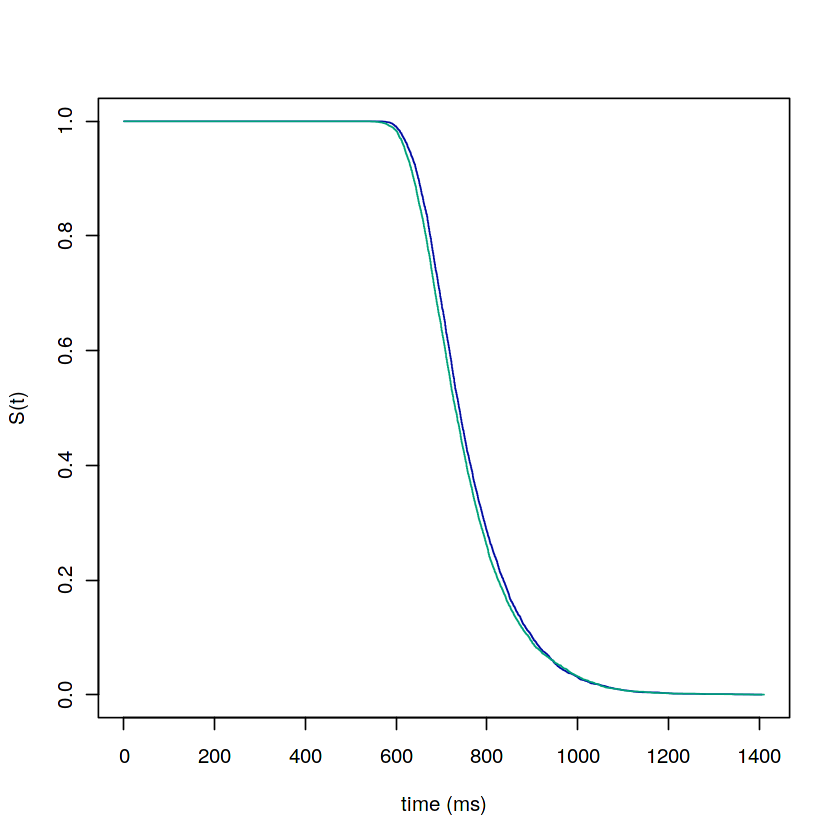

In [19]:
plot(surv.com, xlab = "time (ms)", ylab = "S(t)",
     col = c("#000aa3" # complex words(green)
             ,"#00a37a" # simple words(blue)
            ))

The survival curves for complex and simple words do not show a very clear divergence over time, but the divergence exits, possibly due to the small set of the data set. It is therefore possible that the effect of the predictor complexity is significant, but nonetheless relatively unimportant. Consistent with the previous numerical inspection of the survival curves.

Statistical test

In [20]:
# Statistical test
surv.com.test = survdiff(surv ~ complexity, data = ld.chin)
# Inspect
surv.com.test

Call:
survdiff(formula = surv ~ complexity, data = ld.chin)

                      N Observed Expected (O-E)^2/E (O-E)^2/V
complexity=complex 4542     4542     4697      5.09      10.1
complexity=simple  5060     5060     4905      4.88      10.1

 Chisq= 10.1  on 1 degrees of freedom, p= 0.002 

> p-value is the probablity that the null hypothesis is true. The lower the p−value, the more confidently we can reject the null hypothesis

> Null hypothesis: there is no difference between the hazard curves for long and short words


The p-value(p= 0.002) here is small(smaller than 0.05), we can therefore reject the null hypothesis that there is no difference between the hazard functions for simple and complex words, and conclude that the difference between the hazard functions for simple and comlex words exits.

And the fact that the p-value is not extremely small indicates that it is therefore possible that the effect of the predictor complexity is significant, but nonetheless relatively unimportant, which is consistent with the previous results.


The log-rank test thus confirms the picture that emerged from the inspection of the survival curves. Hazard rates are higher for complex words as compared to simple words. Hence, survival rates are lower for complex words than for simple words.

Categorical predictor complexity **sum**:

* categorical predictor complexity has an effect on the shape of objective functions survival function and hazard function. 

* Hazard rates are higher for complex words as compared to simple words. Hence, survival rates are lower for complex words than for simple words.

* **A categorical predictor(more than 2 values): length of the word**<br>
The length of a words can only be 1, 2, 3, 4 as:

View word length distribution

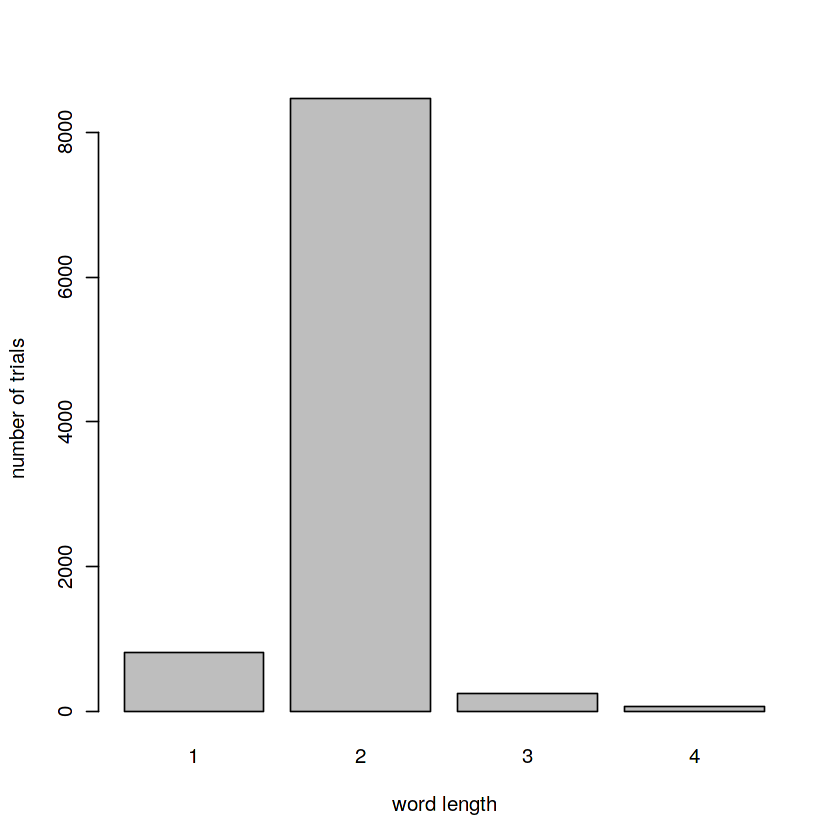

In [21]:
# Generate table of word lengths
tab = table(ld.chin$length)

# Barplot of word lengths
barplot(tab, xlab = "word length", ylab = "number of trials")

Fit survival curves.

In [22]:
# Generate survival curves
surv.len = survfit(Surv(rt, status) ~ length, data = ld.chin)
# Inspect survival curves
surv.len

Call: survfit(formula = Surv(rt, status) ~ length, data = ld.chin)

            n events median 0.95LCL 0.95UCL
length=1  809    809    779     770     796
length=2 8469   8469    730     728     733
length=3  249    249    744     730     757
length=4   75     75    803     787     849

First sight into the survival curves, median response times among different lengths differ. There exists overlap between confidence intervals, but the confidence intervals of different lengths generally do not overlap much. This first insight suggests a difference between the survival curves for words of different lengths.

Inspect survival curves.

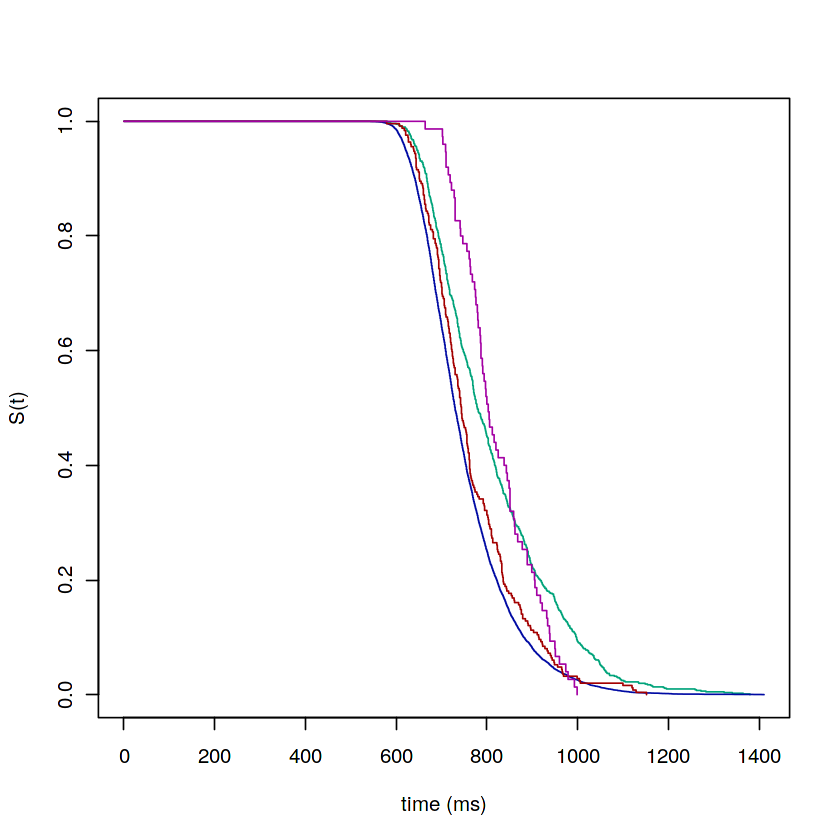

In [23]:
plot(surv.len, xlab = "time (ms)", ylab = "S(t)",
     col = c("#00a37a" # length=1 green
             , "#000aa3" # length=2 blue
             , "#a30000" # length=3 red
             , "#a300a3" # length=4 purple
            ))

The survival curves for words of different lengths generally show a clear divergence over time. Consistent with the fisrt impression gained from the previous numerical inspection of the survival curves. Although the 2 curves of length=2 and length=3 rather stick close to each other, which, also coincide with the previous numerial inspection(similar median response time and overlapping confidence intervals).

Survial rate is biggest for words of length 4, then length 1, then length 3, smallest for words of length 2.

In [24]:
# Statistical test
surv.len.test = survdiff(Surv(rt, status) ~ length,
  data = ld.chin)
# Inspect
surv.len.test

Call:
survdiff(formula = Surv(rt, status) ~ length, data = ld.chin)

            N Observed Expected (O-E)^2/E (O-E)^2/V
length=1  809      809     1234    146.18    172.89
length=2 8469     8469     7982     29.65    180.45
length=3  249      249      269      1.49      1.54
length=4   75       75      117     15.00     15.33

 Chisq= 198  on 3 degrees of freedom, p= <2e-16 

> The number of expected events for a word-length category indicates how many events of interest we would have expected to happen across all time points for the word-length category if the hazard functions for all word-length were identical.

The number of observed events is larger than the number of expected events for words of length=2. By contrast, the number of expected events is larger than the number of observed events for words of length=1, length=3 and length=4. Summed across time points, the hazard rates thus are higher than average for words of length=2 and lower than average for words of length=1, length=3 and length=4.

> The test statistic for the log-rank test and the corresponding p-value provide information about the probability that the null hypothesis is true.

For the current log-rank test, the test statistic is 198 and the p-value is considerably smaller than 0.05. The probability that the null hypothesis that there is no difference between the hazard functions for the word-length categories is true therefore is extremely low. We thus reject this null hypothesis and conclude that there are statistically significant differences between the hazard functions for words of different lengths.

In [25]:
# Statistical test
surv.len.pairwise.test = pairwise_survdiff(Surv(rt, status) ~ length,
  data = ld.chin, p.adjust.method = "none")
# Inspect
surv.len.pairwise.test


	Pairwise comparisons using Log-Rank test 

data:  ld.chin and length 

  1       2       3     
2 < 2e-16 -       -     
3 1.4e-07 0.0312  -     
4 0.8014  9.5e-06 0.0022

P value adjustment method: none 

The output of the pairwise_survdiff() function provides p-values for the pairwise differences between all word lengths.
The pairwise differences between words of length=1 and words of length=2, words of length=3 and words of length=1, words of length=2 and words of length=4 are highly significant, while the difference between words(length=2) and words(length=3), words(length=3) and words(length=4) is considerable but not quite. There is rarely difference between pair words(length=1) and words(length=4), as the correspongding p-value is bigger than 0.05.
Consistent with the numerical and visual inspection of the survival curves above, the post-hoc test for pairwise differences thus indicates that the hazard functions and, by extension, the survival curves are significantly different between words(length=1) and words(length=2), words(length=3) and words(length=1), words(length=2) and words(length=4), different between pairs words(length=2) and words(length=3), words(length=3) and words(length=4), are hardly different between words(length=1) and words(length=4).


Categorical predictor word length sum:

* categorical predictor word length has an effect on the shape of objective functions survival function and hazard function.

* Survial rate is biggest for words of length 4, then length 1, then length 3, smallest for words of length 2. Hence the hazard ratios are the other way around.

* Pairwisely, the significant difference exits between each pair except for words of length 1 and words of length 4.

* **A numerical predictor: log.frequency**

Fit a Cox proportional hazards model.

In [26]:
# Fit Cox proportional hazards model
cox.freq = coxph(Surv(rt,status) ~ log.frequency, data = ld.chin)

# Show model summary
summary(cox.freq)

Call:
coxph(formula = Surv(rt, status) ~ log.frequency, data = ld.chin)

  n= 9602, number of events= 9602 

                  coef exp(coef) se(coef)     z Pr(>|z|)    
log.frequency 0.441463  1.554980 0.005822 75.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
log.frequency     1.555     0.6431     1.537     1.573

Concordance= 0.754  (se = 0.002 )
Likelihood ratio test= 5387  on 1 df,   p=<2e-16
Wald test            = 5750  on 1 df,   p=<2e-16
Score (logrank) test = 5619  on 1 df,   p=<2e-16


> The null hypothesis for the statistical test in a Cox proportional hazards model is that the coefficient for the numerical predictor is zero. The model evaluates whether or not there is enough evidence to reject this null hypothesis through the test statistic z, which is defined as the estimated regression coefficient β divided by its standard error. The corresponding p-value provides the probability of the null hypothesis being true.


For the current model, the p-value is extremely small. We therefore reject the null hypothesis and accept the alternative hypothesis that the coefficient for the numerical predictor(log.frequency) is not zero. The Cox proportional hazards model thus indicates that the frequency of a word influences the shape of the hazard function.

* **the frequency of a word influences the shape of the hazard function**<br>
The regression coefficient for (log) frequency in the Cox proportional hazards model fit to the response time is 0.44(a positive number), which indicates that hazard rates are substantially higher for words with higher frequencies. At each point in time, the probability of an instantaneous response provided that no response was registered prior to that point in time thus is higher for high frequency words as compared to low frequency words.<br>
* **how the frequency of a word influences the shape of the hazard function**<br>
For the current model, the value of exp (β ) is 1.555. Hazard rates thus are higher for words with a higher frequency. (The quantity exp (β ) is referred to as the hazard ratio. The hazard ratio is the number by which that hazard rate is multiplied when the value of the predictor is increased by 1. Hazard ratio that are greater than 1 indicate increased hazard rates for higher predictor values.)

Fit survival curves

In [27]:
# Create data frame for predictions
newdata.freq = data.frame("log.frequency" =
  quantile(ld.chin$log.frequency, c(0.1, 0.5, 0.9)))
# Inspect data frame
newdata.freq
# Generate survival curves
surv.freq = survfit(cox.freq, newdata = newdata.freq)
# Inspect survival curves
surv.freq

,log.frequency
,<dbl>
10%,-1.166998
50%,1.209139
90%,3.880623


Call: survfit(formula = cox.freq, newdata = newdata.freq)

       n events median 0.95LCL 0.95UCL
10% 9602   9602    825     821     829
50% 9602   9602    738     735     740
90% 9602   9602    678     677     680

The median response times for words at the 0.10, 0.50, and 0.90 quantiles of the word frequency distribution are 825 ms, 738 ms, and 678 ms respectively. Consistent with the positive hazard ratio for (log) frequency in the Cox proportional hazards model, response times thus are shorter for high frequency words. The effect of word frequency is large. The difference between the median response times for words at the 0.10 and 0.90 quantile is no less than 147 ms.

Inspect survival curves: obtain more detailed insight into the survival function.

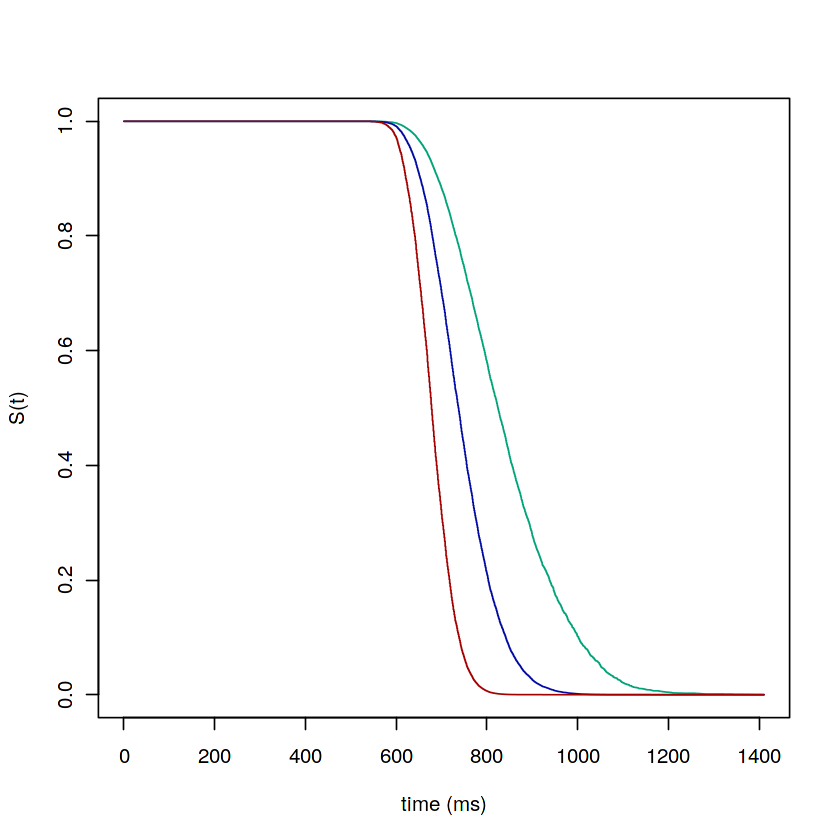

In [28]:
# Plot survival curves
plot(surv.freq, xlab = "time (ms)", ylab = "S(t)",
     col = c("#00a37a" # green(low)
             , "#000aa3" # blue(medium)
             , "#a30000" # red(high)
            ))

* **the three curves**<br>
The survival curves for the low (0.10 quantile), medium (0.50 quantile), and high (0.90 quantile) frequency words deviate to a considerable extent. Survival probabilities are higher for low frequency words as compared to high frequency words throughout the response time window. 

* **curves shape**<br>
The survival curves for the three values of word frequency deviate in a fan-like manner, before converging again during the later stages of the response time window. The fan-like deviation of the survival curves is a typical pattern of results for a Cox proportional hazards model due to the assumption that the ratio of hazard rates for different predictor values is required to be constant over time. This calls for a further check on the proportional harzards assumption.

Check the proportional harzards assumption

In [29]:
# Check proportional hazards assumption
cox.zph.freq = cox.zph(cox.freq)
# Inspect results
cox.zph.freq

              chisq df      p
log.frequency   280  1 <2e-16
GLOBAL          280  1 <2e-16

The p-value returned by cox.zph() function is extremely small. We therefore have to reject the null hypothesis that the proportional hazards assumption(The Cox proportional hazards model assumes that hazard ratios are constant over time.) holds true. The results of the test for proportional hazards indicates that a Cox proportional hazards model does not accurately capture the effect of word frequency on the hazard function.

Plot the (scaled) Schoenfeld residuals: visualize the deviation from the proportional hazards assumption

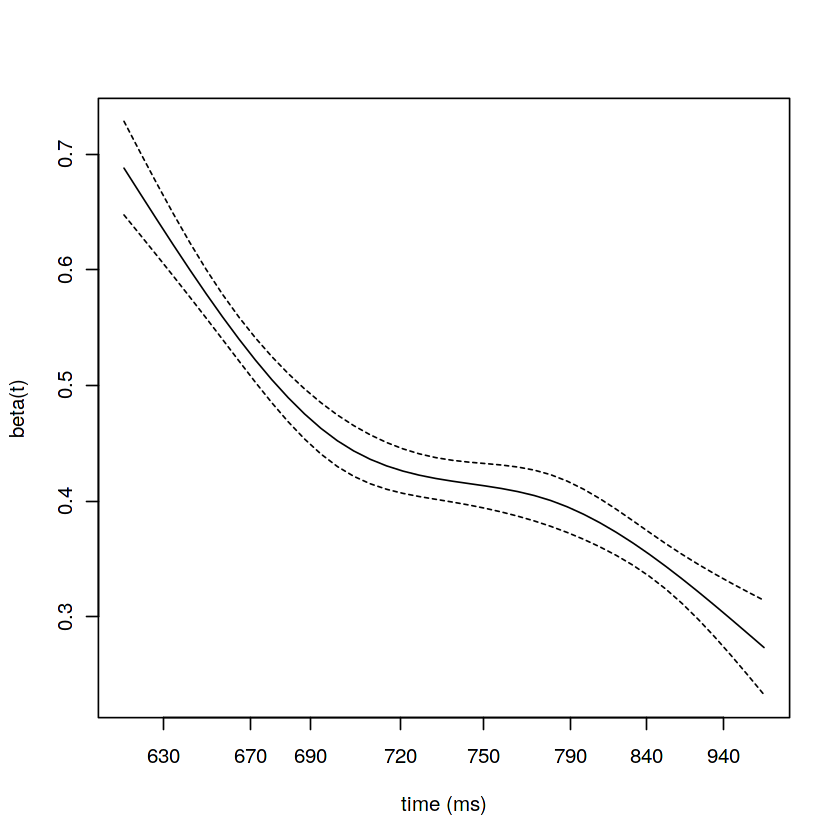

In [30]:
# Plot Schoenfeld residuals
plot(cox.zph.freq, resid = FALSE, xlab = "time (ms)", ylab = "beta(t)")

> If the proportional hazards assumption holds true, the curve for the Schoenfeld residuals should be a straight line with a slope of 0 (i.e., a flat line).

The fact that the curve for the Schoenfeld residuals is not a straight line with a slope of 0 (i.e., a flat line) rejects the proportional hazards assumption that the hazard ration is constant over time.

This confirms that the Cox proportional hazards model does not provide an adequate estimate of the word frequency effect and calls for a model that allows for predictor effects that vary as a function of time.

Numerical predictor (log) frequency sum:

* The frequency of a word influences the shape of the hazard function. At each point in time, the probability of an instantaneous response provided that no response was registered prior to that point in time is higher for high frequency words as compared to low frequency words.

* The frequency of a word influences the shape of the survival function. Survival probabilities are higher for low frequency words as compared to high frequency words throughout the response time window.

*A more precise capture of the predictor effect over time:*

* The hazard ration is not constant over time. 


Fit an Aalen additive hazards model

As:
> To overcome the limitation of the Cox proportional hazards model and its extensions, Aalen proposed a model that allows for predictor effects that vary as a function of time.

In [31]:
# Fit Aalen additive hazards model to the data
aareg.freq = aareg(Surv(rt,status) ~ log.frequency, data = ld.chin) 
# Inspect results
aareg.freq

Call:
aareg(formula = Surv(rt, status) ~ log.frequency, data = ld.chin)

  n= 9602 
    588 out of 590 unique event times used

                 slope     coef se(coef)    z p
Intercept     0.001190 1.75e-04 2.06e-06 84.7 0
log.frequency 0.000883 8.68e-05 1.42e-06 61.1 0

Chisq=3736.97 on 1 df, p=<2e-16; test weights=aalen

* **slope**<br>
> The value of slope is based on a (weighted) linear regression of the cumulative coefficient plot (see below) and provides an overall estimate of the nature of the effect. 

The value of the “slope” column for (log) frequency is positive, which indicates that overall hazard rates are higher for high frequency words.

* **The overall nature of the word frequency effect**<br>
is consistent with the results of the Cox proportional hazards model. Whereas the qualitative nature of a predictor effect needs to be constant over time in the Cox proportional hazards model, however, the qualitative nature of a predictor effect may vary as a function of time in the Aalen additive hazards model.

> To find out if the effect of word frequency on the hazard function varies as a function of time, we plot the results of the Aalen additive regression model.  

Plot cumulative coefficient curve.

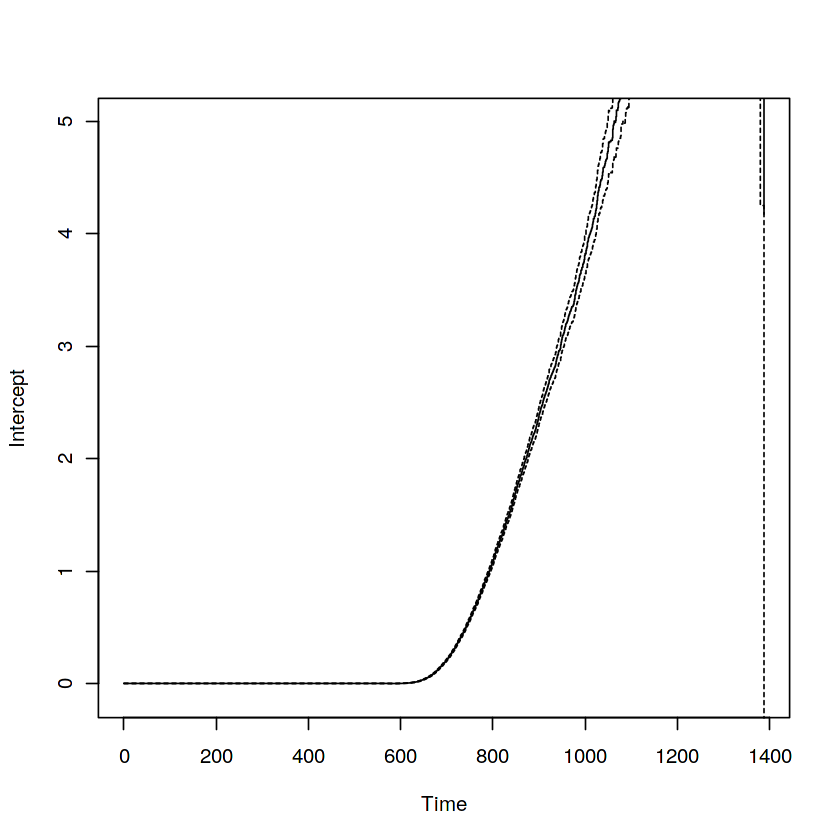

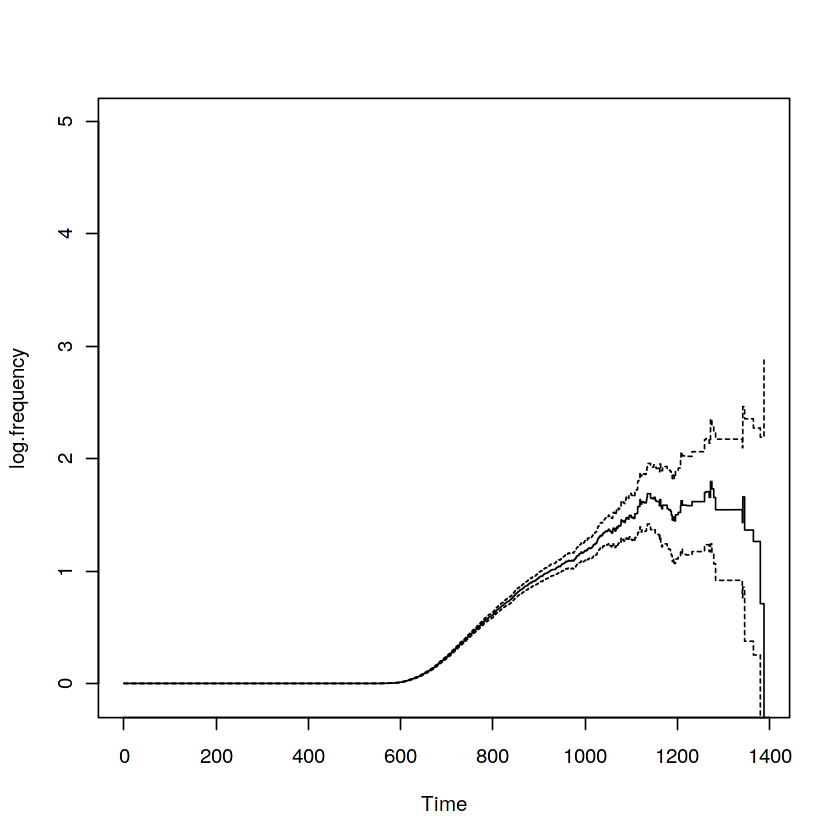

In [32]:
# Cumulative hazard plot
 plot(aareg.freq, ylim=c(-0.1,5))

Between 600 ms and 1200 ms after stimulus onset, the cumulative coefficient generally increases. At this part of the response time window, the hazard rate thus is higher for high frequency words than for low frequency words. At 1, 200 ms after stimulus onset, however, the cumulative coefficient starts to decrease. For later parts of the response time window, the hazard rate thus is lower for high frequency words.

* **Model with multiple predictors:** <br>
word length(as a categorical predictor), log.frequency(as a numerical predictor), sqrt.strokes(as a numerical predictor)

A Cox proportional hazards model with multiple predictors:
* categorical predictor: word length(length)
* numerical predictor: log of word frequency(log.frequency)
* numerical predictor: square of number of strokes of a word(sqrt.strokes)

In [33]:
# creating categorical predictor out of numerical length
ld.chin$len = as.factor(ld.chin$length)

In [34]:
# Fit Cox proportional hazards model
cox.mult = coxph(Surv(rt,status) ~ log.frequency + sqrt.strokes + len,
                 data = ld.chin)

summary(cox.mult)

Call:
coxph(formula = Surv(rt, status) ~ log.frequency + sqrt.strokes + 
    len, data = ld.chin)

  n= 9602, number of events= 9602 

                   coef exp(coef)  se(coef)      z Pr(>|z|)    
log.frequency  0.456971  1.579283  0.006091 75.025  < 2e-16 ***
sqrt.strokes  -0.040028  0.960762  0.016555 -2.418   0.0156 *  
len2           0.569263  1.766964  0.040350 14.108  < 2e-16 ***
len3           1.036213  2.818524  0.077931 13.297  < 2e-16 ***
len4           0.848692  2.336589  0.127648  6.649 2.96e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
log.frequency    1.5793     0.6332    1.5605    1.5982
sqrt.strokes     0.9608     1.0408    0.9301    0.9924
len2             1.7670     0.5659    1.6326    1.9124
len3             2.8185     0.3548    2.4193    3.2836
len4             2.3366     0.4280    1.8194    3.0008

Concordance= 0.759  (se = 0.002 )
Likelihood ratio test= 5680  on 5 df,   p=<2e-16

> The model evaluates whether or not we have enough evidence to reject two types of null hypotheses: the null hypothesis for the model as a whole and the null hypotheses for the effects of individual predictors. The null hypothesis for the model as a whole is that all estimated coefficients are zero. Conceptually, the null hypothesis of the model thus is that neither (log) frequency, nor word length, nor (square) number of strokes influence the shape of the hazard function.

* ** at least one of the predictors has a significant effect on the shape of the hazard function<br>**
The model summary reports the results of three statistical tests of the null hypothesis for the model as a whole: the likelihood ratio test, the Wald test, and the logrank test. The p-values for the corresponding test statistics are extremely small. We therefore reject the null hypothesis and accept the alternative hypothesis that at least one of the predictors (log) frequency, word lengh, and (square) number of strokes has a significant effect on the shape of the hazard function.

Further,

* **word frequency, word length category, and  number of strokes all have an effect on the shape of the hazard function.**<br>
The p-values for (log) frequency, word length category, and (square) number of strokes are all small. We therefore reject the null hypothesis for each predictor and accept the alternative hypothesis that the coefficient of the predictor is not zero. The results of the Cox proportional hazards model thus indicate that word frequency, word length category, and number of strokes all have a significant effect on the shape of the hazard function.

* **the qualitative and quantitative nature of the predictor effects** <br>
The coefficient for (log) frequency is positive (0.46), whereas the coefficient for (square) strokes is negative (−0.04). Hazard rates thus are higher for words with a higher frequency, but lower for words with more strokes.
<br>

> The coefficients for the other values of a categorical predictor are adjustment to hazard rates as compared to the reference level.

The refence level is words(len=1).
The coefficients for the word length categories indicate that hazard rates are higher for words(len=2), words(len=3) and words(len=4) as compared to words(len=1). The p-values for the corresponding values of the test statistic z are low. We therefore conclude that the shape of the hazard function is different for words(len=2), words(len=3) and words(len=4) as compared to words(len=1).

In [35]:
# Create data frame for predictions
newdata.freq = data.frame(
  "log.frequency" = quantile(ld.chin$log.frequency,
                             c(0.1, 0.5, 0.9)),
  "sqrt.strokes" = mean(ld.chin$sqrt.strokes),
"len" = '1' )
# Inspect data frame
newdata.freq

,log.frequency,sqrt.strokes,len
,<dbl>,<dbl>,<fct>
10%,-1.166998,4.003188,1
50%,1.209139,4.003188,1
90%,3.880623,4.003188,1


In [36]:
# Generate survival curves
surv.freq = survfit(cox.mult, newdata = newdata.freq)
# Inspect survival curves
surv.freq

Call: survfit(formula = cox.mult, newdata = newdata.freq)

       n events median 0.95LCL 0.95UCL
10% 9602   9602    893     880     903
50% 9602   9602    776     770     782
90% 9602   9602    700     696     705

In [37]:
# Create summary of survival curves
surv.freq.sum = surv_summary(surv.freq)
# Define columns of interest
cols = c("time", "surv", "upper", "lower", "strata")
# Inspect survival curves at 600 ms
surv.freq.sum[which(surv.freq.sum$time==600), cols]

,time,surv,upper,lower,strata
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
42,600,0.9982844,0.9986204,0.9979486,10%
632,600,0.9949273,0.9958891,0.9939664,50%
1222,600,0.9829081,0.9861029,0.9797238,90%


Consistent with the results of the Cox proportional hazards model, survival probabilities are higher for high frequency words as compared to low frequency words.

Plot survival curves for word frequency.


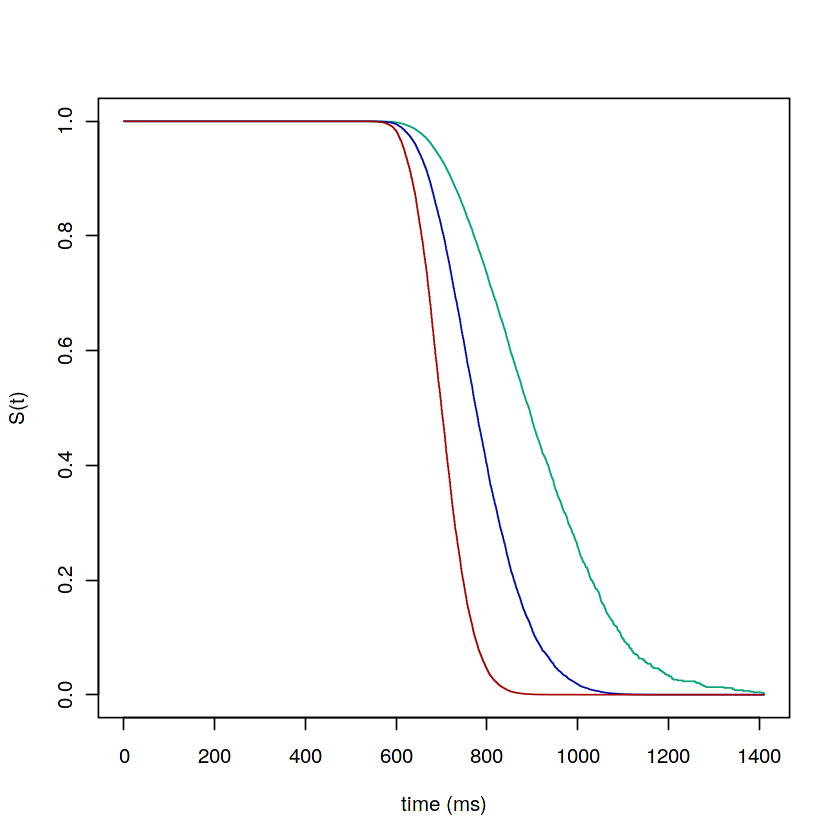

In [38]:
# Plot survival curves
plot(surv.freq, xlab = "time (ms)", ylab = "S(t)",
     col = c("#00a37a" # green(low)
             , "#000aa3" # blue(medium)
             , "#a30000" # red(high)
             ))

Consistent with the substantial coefficient for (log) frequency in the Cox proportional hazards model, the survival curves for the low (0.10 quantile), medium (0.50 quantile), and high (0.90 quantile) frequency words differ substantially. Survival probabilities are quite a bit higher for high frequency words as compared to low frequency words throughout the response time window.

The distance between the survival curves for the three selected quantiles is considerable.
The frequency of a word thus has a substantial effect on the shape of the hazard function.

Plot survival curves for number of word strokes.

In [39]:
# Create data frame for predictions
newdata.strok = data.frame(
  "sqrt.strokes" = quantile(ld.chin$sqrt.strokes,
                             c(0.1, 0.5, 0.9)),
  "log.frequency" = mean(ld.chin$log.frequency),
"len" = '1' )
# Inspect data frame
newdata.strok

,sqrt.strokes,log.frequency,len
,<dbl>,<dbl>,<fct>
10%,3.162278,1.282687,1
50%,4.000000,1.282687,1
90%,4.795832,1.282687,1


In [40]:
# Generate survival curves
surv.strok = survfit(cox.mult, newdata = newdata.strok)
# Inspect survival curves
surv.strok

Call: survfit(formula = cox.mult, newdata = newdata.strok)

       n events median 0.95LCL 0.95UCL
10% 9602   9602    770     765     777
50% 9602   9602    773     768     780
90% 9602   9602    776     769     783

In [41]:
# Create summary of survival curves
surv.strok.sum = surv_summary(surv.strok)
# Define columns of interest
cols = c("time", "surv", "upper", "lower", "strata")
# Inspect survival curves at 600 ms
surv.strok.sum[which(surv.strok.sum$time==600), cols]

,time,surv,upper,lower,strata
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
42,600,0.9945753,0.9955910,0.9935605,10%
632,600,0.9947537,0.9957476,0.9937607,50%
1222,600,0.9949177,0.9959091,0.9939273,90%


Consistent with the results of the Cox proportional hazards model, survival probabilities are higher for words with more strokes as compared to words with fewer strokes. However the difference is not quite significant.

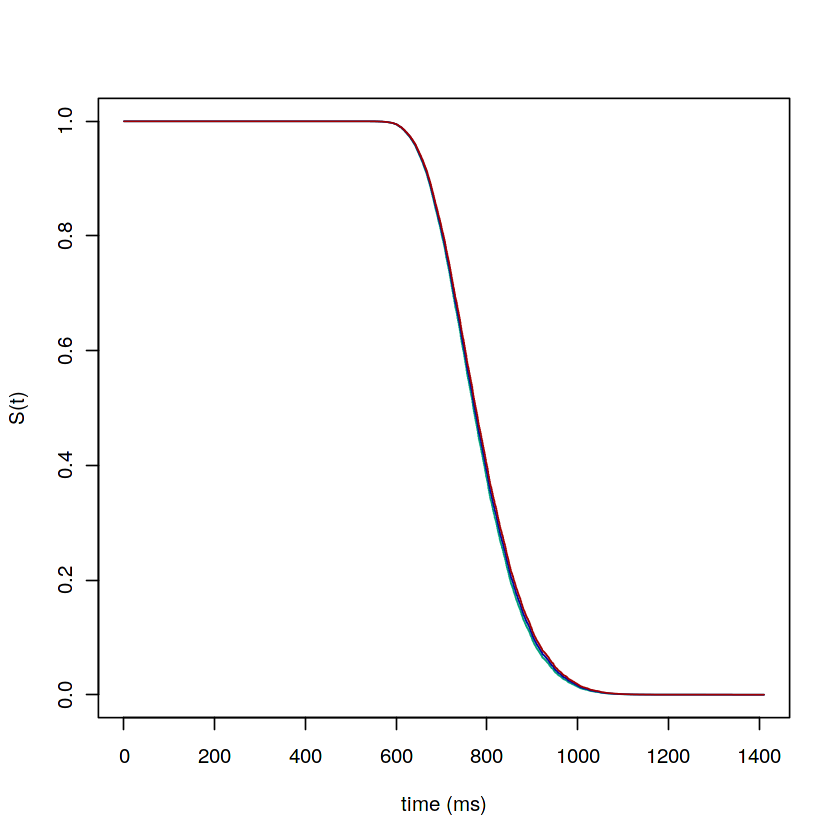

In [42]:
# Plot survival curves
plot(surv.strok, xlab = "time (ms)", ylab = "S(t)",
     col = c("#00a37a" # green(low)
             , "#000aa3" # blue(medium)
             , "#a30000" # red(high)
             ))

The survival curves are hardly distinguishable, which is consistent with the results of the Cox proportional hazards models that the p-value is not significantly small but still smaller than 0.05. The size of the effect of this predictor number of strokes is small. But it could still be seen from this plot that survival probabilities are higher for words with more strokes as compared to words with fewer strokes, which is consitent with the previous observation.


Plot survival curves for words of different lengths.

In [43]:
# Create data frame for predictions
newdata.len = data.frame(
  "len" = c('1','2','3','4'),
  "sqrt.strokes" = mean(ld.chin$sqrt.strokes),
"log.frequency" = mean(ld.chin$log.frequency) )
# Inspect data frame
newdata.len

len,sqrt.strokes,log.frequency
<fct>,<dbl>,<dbl>
1,4.003188,1.282687
2,4.003188,1.282687
3,4.003188,1.282687
4,4.003188,1.282687


In [44]:
# Generate survival curves
surv.len = survfit(cox.mult, newdata = newdata.len)
# Inspect survival curves
surv.len

Call: survfit(formula = cox.mult, newdata = newdata.len)

     n events median 0.95LCL 0.95UCL
1 9602   9602    773     768     780
2 9602   9602    733     731     735
3 9602   9602    708     701     715
4 9602   9602    718     707     732

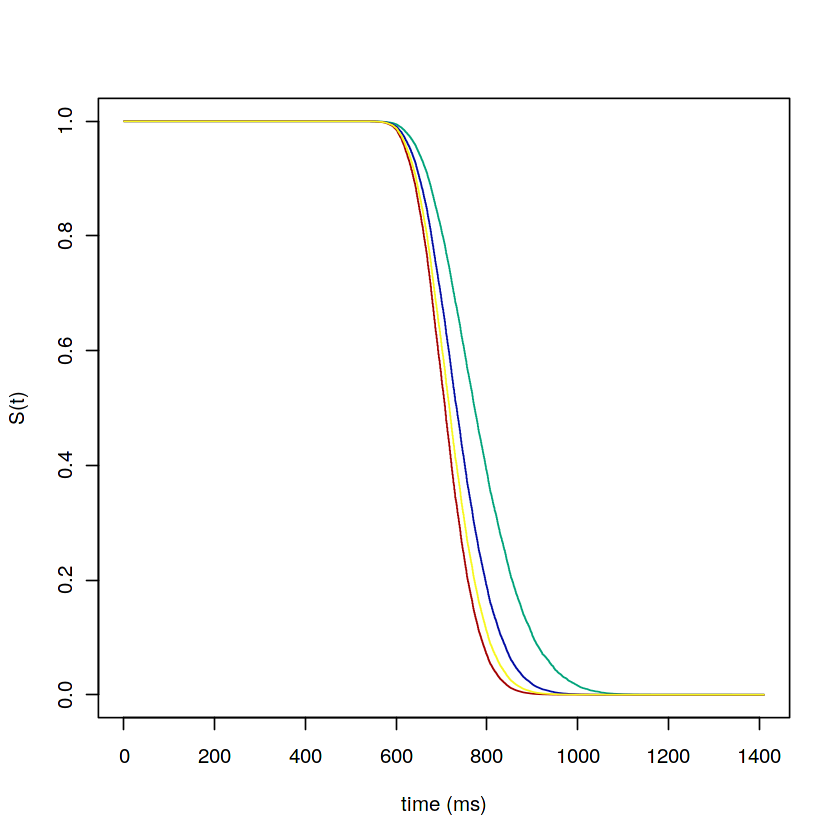

In [45]:
# Plot survival curves
plot(surv.len, xlab = "time (ms)", ylab = "S(t)",
     col = c("#00a37a" # green(len=1)
             , "#000aa3" # blue(len=2)
             , "#a30000" # red(len=3)
             , "#f7f71e" # yellow(len=4)
            ))

The fact that the curves are distinguishable suggests that words of diffence lengths have different probabilities, which is also consistent with the previous test results.
Survival probabilities are lowest for words(len=3), and highest for words(len=4).

The distance between the survival curves for the 4 categories is considerable. The length of a word thus has a substantial effect on the shape of the hazard function.

Check proportional hazards assumption.

In [46]:
# Check proportional hazards assumption
cox.zph.mult = cox.zph(cox.mult)
# Inspect results
cox.zph.mult

               chisq df       p
log.frequency 315.46  1 < 2e-16
sqrt.strokes    4.91  1   0.027
len            71.01  3 2.6e-15
GLOBAL        411.83  5 < 2e-16

The p-values for the predictors (log) frequency, (square) frequency, and word length category are small, as is the p-value for the model as a whole. We therefore reject the null hypothesis that hazard ratios are constant over time for each predictor, as well as for the model as a whole.

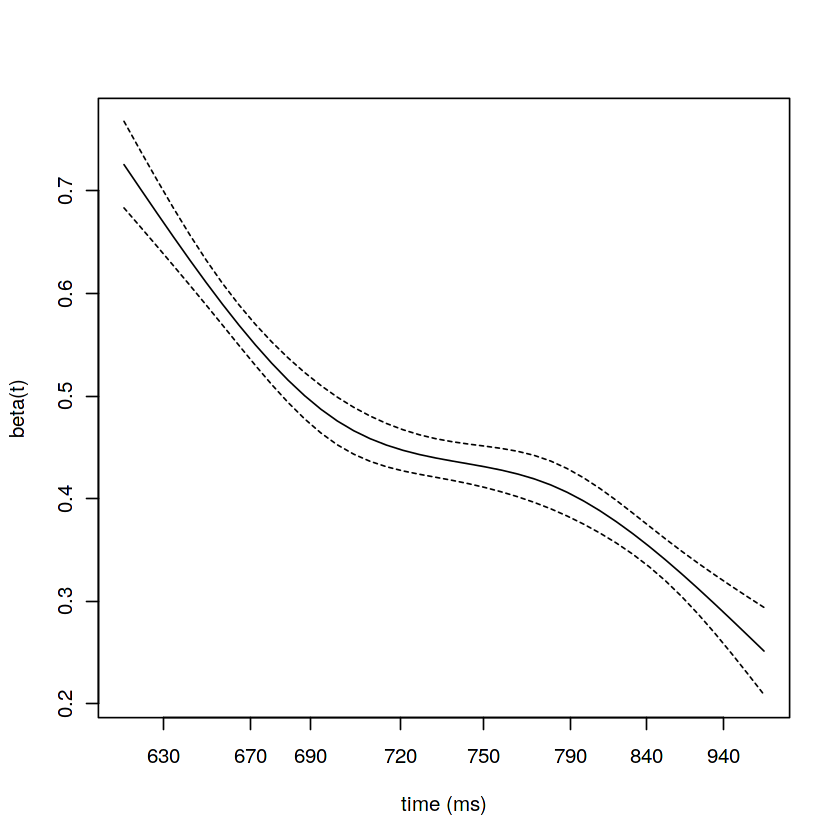

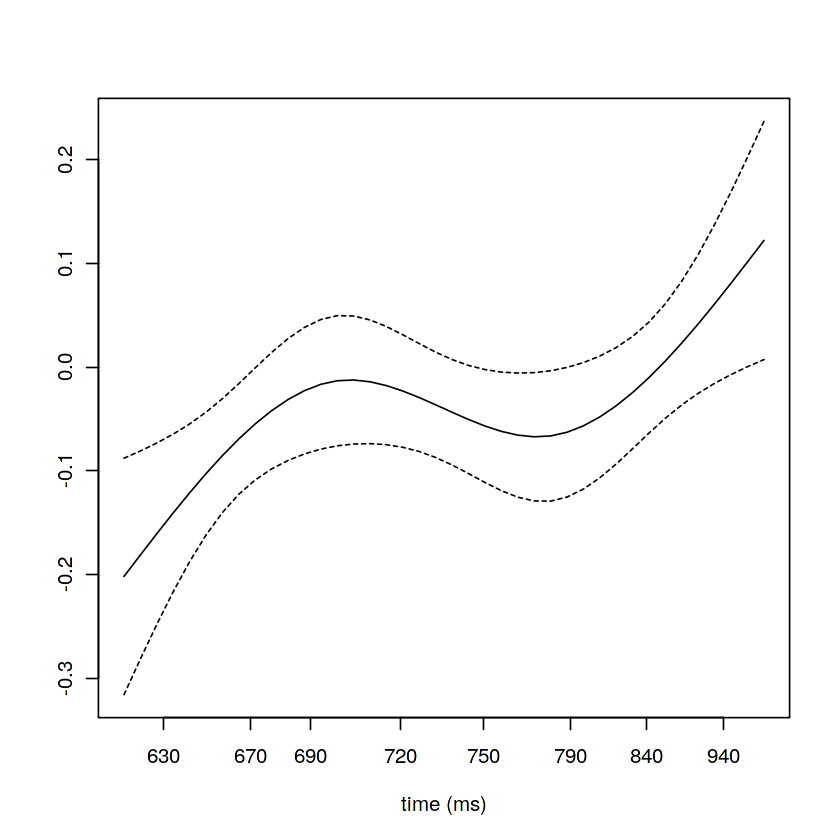

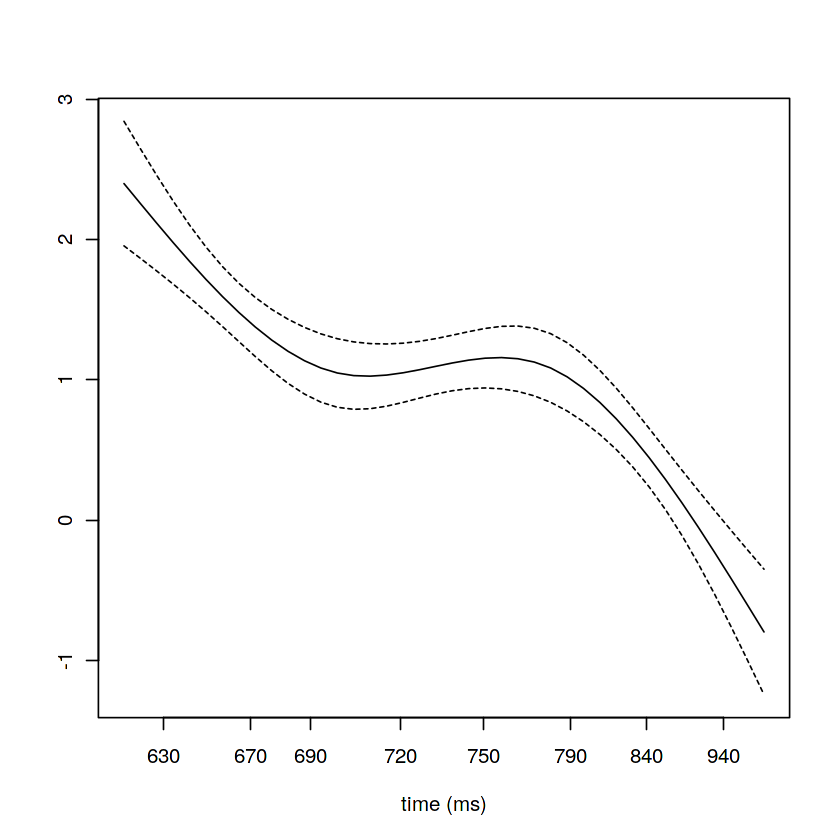

In [47]:
# Plot Schoenfeld residuals
plot(cox.zph.mult, resid = FALSE, xlab = "time (ms)", ylab = "beta(t)")

The Schoenfeld residuals are not constant over time, neither for word frequency, nor for number of strokes, nor for word length category. We conclude that the Cox proportional hazards model does not accurately capture the influence of the frequency of a word, the number of strokes in a word, and the word length category of a word on the shape of the hazard function.

Fit an Aalen additive hazards model.

> The Aalen additive hazards model provides an alternative to the Cox proportional hazards model, that does not assume that hazard ratios are constant over time. As was the case for the Cox proportional hazards model, the Aalen additive hazards model allows for multiple predictors. Each predictor may be numerical or categorical in nature.

In [48]:
# Fit Aalen additive hazards model to the data
aareg.mult = aareg(Surv(rt,status) ~ log.frequency + sqrt.strokes + len,
                   data = ld.chin)
# Show summary
aareg.mult

Call:
aareg(formula = Surv(rt, status) ~ log.frequency + sqrt.strokes + 
    len, data = ld.chin)

  n= 9602 
    576 out of 590 unique event times used

                  slope      coef se(coef)     z        p
Intercept            NA        NA       NA    NA       NA
log.frequency  0.000882  8.67e-05 1.44e-06 60.10 0.00e+00
sqrt.strokes  -0.000199 -1.85e-05 3.51e-06 -5.26 1.44e-07
len2           0.000570  6.76e-05 7.14e-06  9.47 2.87e-21
len3           0.001520  1.70e-04 1.47e-05 11.60 4.49e-31
len4                 NA        NA       NA    NA       NA

Chisq=NA on 5 df, p=NA; test weights=aalen

Since when fitting Aalen additive hazards model to the data frame where length is considered catgorical gets abnormal results: len=4 line filled with NAs. Suspect due to the fact that the number of words of length 4 is too small.

Solution 1: create a tmp data set without words(len=4)

In [49]:
ld.chin.tmp = ld.chin[-which(ld.chin$length == 4),]
tail(ld.chin.tmp)
tail(ld.chin)

,word,rt,log.frequency,length,sqrt.strokes,snd,log.nwf,status,time,complexity,len
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
9522,节目表,778,-1.685779,3,4.242641,0.9123003,4.675939,1,778,complex,3
9523,货柜车,948,-2.707550,3,4.582576,0.9569693,4.859812,1,948,complex,3
9524,贵金属,891,-3.807663,3,5.385165,0.9087560,4.532599,1,891,complex,3
9525,顾问团,999,-2.825146,3,4.690416,0.9230818,4.077537,1,999,complex,3
9526,驯兽师,754,-1.859824,3,4.795832,0.9036412,3.646320,1,754,complex,3
9527,鸡尾酒,701,1.383315,3,4.898979,0.9007362,4.229264,1,701,complex,3


,word,rt,log.frequency,length,sqrt.strokes,snd,log.nwf,status,time,complexity,len
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
9597,节衣缩食,878,-1.85982420,4,5.830952,0.9224802,4.418841,1,878,complex,4
9598,谋财害命,805,-1.64662070,4,6.000000,0.9291793,4.047428,1,805,complex,4
9599,贪得无厌,791,-0.52256088,4,5.385165,0.9090908,4.842217,1,791,complex,4
9600,闷闷不乐,710,0.07908841,4,4.898979,0.9024619,5.350673,1,710,complex,4
9601,闻风丧胆,843,-1.34899858,4,5.477226,0.9147592,4.499810,1,843,complex,4
9602,顾全大局,741,-1.76901998,4,5.099020,0.9032092,5.330300,1,741,complex,4


This cell crashes the CPU.

In [50]:
# Fit Aalen additive hazards model to the data
# aareg.mult.mod = aareg(Surv(rt,status) ~ log.frequency + sqrt.strokes + len,data = ld.chin.tmp)
# Show summary
# aareg.mult.mod

Solution 1 fails

Alternative solution: create another categorical predictor of word length length.cat to enlarge the number of trial of each category

In [51]:
# create a categorical predictor length.cat
ld.chin$length.cat = ifelse(ld.chin$length <= 2, "short", "long")
head(ld.chin)

,word,rt,log.frequency,length,sqrt.strokes,snd,log.nwf,status,time,complexity,len,length.cat
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>
1,凡,778,3.566407,1,1.732051,0.9775594,3.091042,1,778,simple,1,short
2,口,682,5.042779,1,1.732051,0.9702419,5.283204,1,682,simple,1,short
3,土,705,3.026034,1,1.732051,0.9678224,4.532599,1,705,simple,1,short
4,女,681,6.428571,1,1.732051,0.9726942,4.852030,1,681,simple,1,short
5,小,651,7.564045,1,1.732051,0.9775589,5.703782,1,651,simple,1,short
6,山,668,4.816952,1,1.732051,0.9711855,5.342334,1,668,simple,1,short


In [52]:
# Fit Aalen additive hazards model to the data
aareg.mult = aareg(Surv(rt,status) ~ log.frequency + sqrt.strokes + length.cat,
                   data = ld.chin)
# Show summary
aareg.mult

Call:
aareg(formula = Surv(rt, status) ~ log.frequency + sqrt.strokes + 
    length.cat, data = ld.chin)

  n= 9602 
    580 out of 590 unique event times used

                    slope      coef se(coef)     z      p
Intercept              NA        NA       NA    NA     NA
log.frequency    0.000892  8.82e-05 1.44e-06 61.40 0.0000
sqrt.strokes    -0.000087 -5.21e-06 3.12e-06 -1.67 0.0949
length.catshort        NA        NA       NA    NA     NA

Chisq=NA on 3 df, p=NA; test weights=aalen

The alternative solution fails too. The failure suggests the small number of trials in each category does not account for the NA fact.

Desperate solution: consider the numerical length predictor.

In [53]:
# Fit Aalen additive hazards model to the data
aareg.mult = aareg(Surv(rt,status) ~ log.frequency + sqrt.strokes + length,
                   data = ld.chin)
# Show summary
aareg.mult

Call:
aareg(formula = Surv(rt, status) ~ log.frequency + sqrt.strokes + 
    length, data = ld.chin)

  n= 9602 
    582 out of 590 unique event times used

                  slope      coef se(coef)     z        p
Intercept      0.000856  1.52e-04 1.26e-05 12.10 1.52e-33
log.frequency  0.000881  8.69e-05 1.42e-06 61.20 0.00e+00
sqrt.strokes  -0.000200 -1.86e-05 3.50e-06 -5.31 1.10e-07
length         0.000555  6.64e-05 5.33e-06 12.50 1.39e-35

Chisq=3939.26 on 3 df, p=<2e-16; test weights=aalen

> The null hypothesis for the chi-square test of the model as a whole is that none of the predictors influences the shape of the hazard function. 

The p-value of this test is very small. We therefore reject the null hypothesis and conclude that at least one of the predictor (log) frequency, (square) number of strokes, and word length influences the shape of the hazard function.

> The statistical tests for the predictor effects provide information about the contribution of the individual predictors.  

The numerical predictors all have strong effect onthte shape of the hazard function given the corresponding small p-values.

> The value of the column “slope” provides an overall estimate of the qualitative nature of a predictor effect.

The positive value of “slope” for (log) frequency and length indicates that on average hazard rates are higher for high frequency words and words with more characters. By contrast, the negative value of “slope” for (square) strokes suggests that on average hazard rates are lower for words with more strokes.

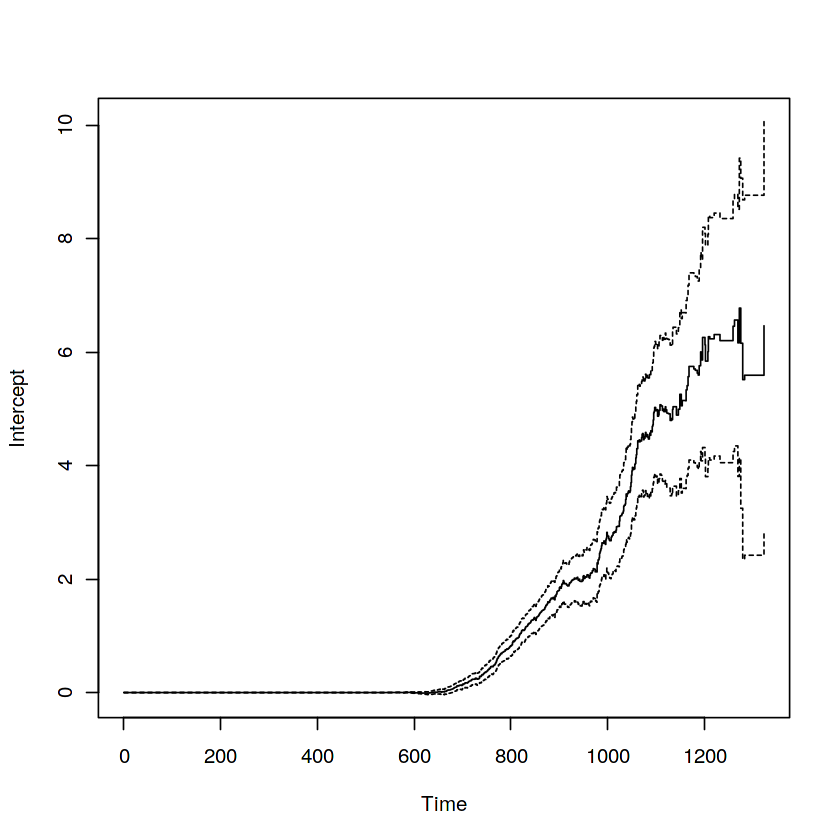

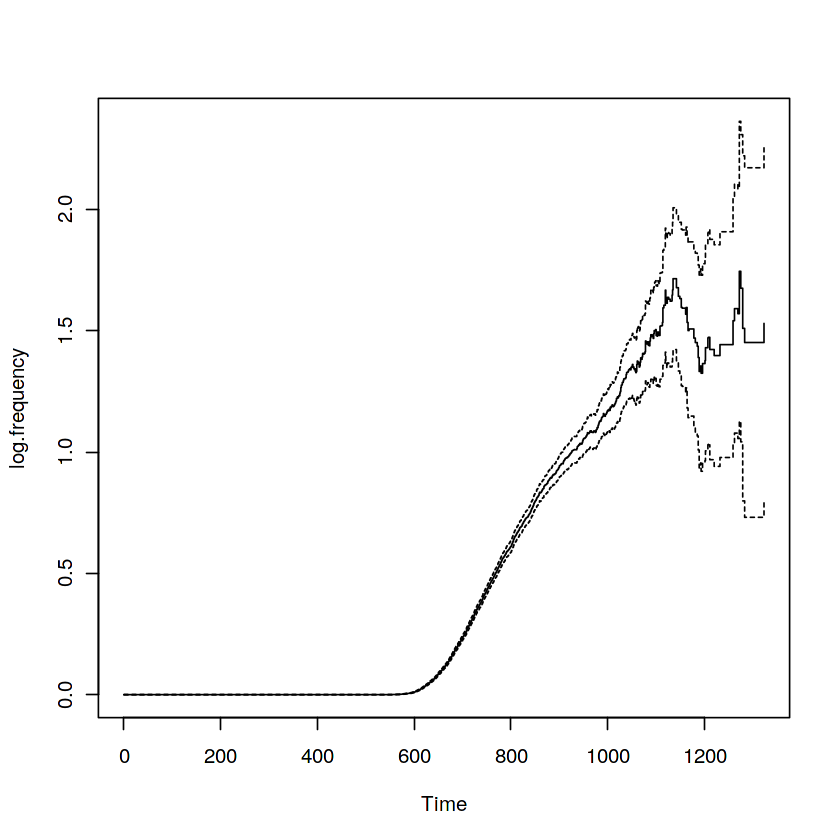

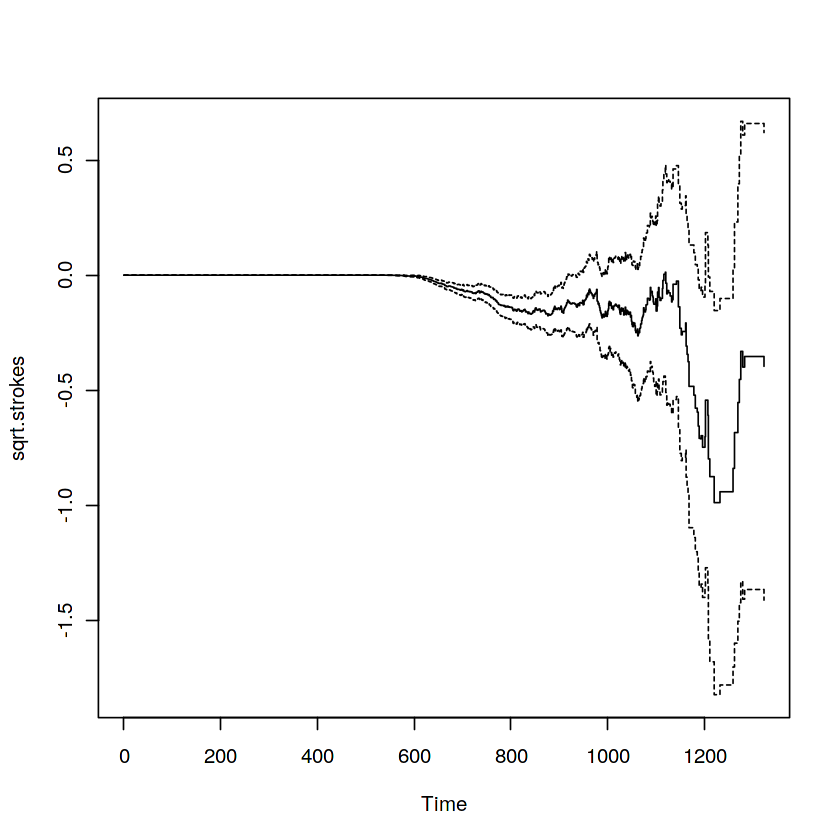

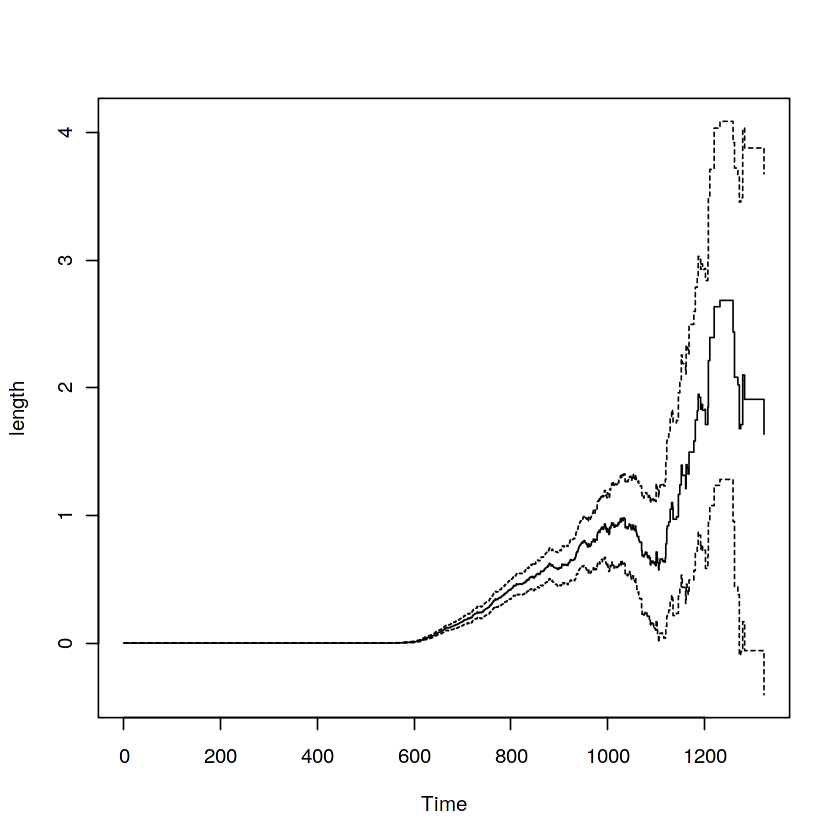

In [54]:
# Cumulative hazard plot
plot(aareg.mult)

* The baseline hazard

The baseline hazard steadily increases over time, indicating that at each point in time the probability of a response (provided that no response was registered prior to that point in time) is greater than 0.
* log.frequency

Consistent with the results for the Aalen additive hazards model with a single numerical predictor reported previously, the curve for the cumulative coefficient for (log) frequency is convex in nature. 
The cumulative coefficient increases between 600 ms and 1150 ms, after stimulus onset and decreases between 1150 ms and 1200.The effect of word frequency thus is characterized by a substantial temporal development.

* sqrt.strokes

The curve for the cumulative coefficient of (square) number of strkoes is convex in nature. 
During the initial stages of the response time window, the cumulative hazard function decreases. Given that the slope of the cumulative hazard function is the value of the hazard function, hazard rates thus are lower for words with more strokes.
The initial decrease in the cumulative coefficient drives the overall nature of the word strokes effect in the Cox proportional hazards model. During the later stages of the response time window, however, the adjustment to the cumulative hazard function for word strokes increases. During these stages of the response time window, hazard rates thus are higher for words with more strokes.

* length

The curve for the cumulative coefficient of (square) number of strkoes is convex in nature. 
During the initial stages of the response time window, the cumulative hazard function increases. Given that the slope of the cumulative hazard function is the value of the hazard function, hazard rates thus are higher for longer words.
The initial decrese in the cumulative coefficient drives the overall nature of the word strokes effect in the Cox proportional hazards model. During the later stages of the response time window, however, the adjustment to the cumulative hazard function for word length decreases. During these stages of the response time window, hazard rates thus are lower for longer words.



**Brief sum:**

Above we had 4 models:

* model with individual categorical predictor complexity
* model with individual categorical predictor word length
* model with individual numerical predictor (log) word frequenccy
* model with multiple predictors: word length, (square) number of strokes and (log) word frequency

The predictors we disccused above all have an effect on the shape of objective functions, while among them number of strokes has the relatively least important effect. 

Furthermore, hazard ratios is not constant over time for any predictor discussed above, neither in the case of the model with multiple predictors as a whole.

**Irelevant overthinking:**

The number of strokes of each word does not have a very significant effect on the response tuple while the length of each word influence very much. Comparing to the previous analysis results for blp data, where word length predictor also has a significant effect on the shape of objective functions, the predictor effect is consistent across data sets of language with logographic and alphabetic writing system, which suggests the even in the case of a language with logographic writing system like Chinese, the complexity of each character does not have strong effect on response tuple in wrod decision task. The effect of the complexity of each character is way less stronger than that of number of characters.

Generate report

In [55]:
fake_data = data.frame("content" = "none")
save(fake_data,file="fake_data.rda")